In [15]:
#!pip install tensorflow

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error , mean_absolute_percentage_error

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [19]:
df =pd.read_csv("C:\\Users\\data2\\OneDrive\\Masaüstü\\codeware\\TASKS\\6task\\dataset.csv")

In [20]:
#df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.drop(columns=["sID","Datetime"])

In [49]:
doksan = len(df) *0.9
doksan = round(doksan)

In [71]:
df_train = df.iloc[0:doksan]
df_test = df.iloc[doksan:]

### LAG OLUSTUR

In [23]:
def create_lag(X,n):
    lag_df=X.copy()
    for i in range(1,(n+1)):
        lag_df[f"lag_{i}"]=X["Count"].shift(i)
        lag_df = lag_df.dropna()
    return lag_df

In [24]:
lagged_train =create_lag(df_train,4)
lagged_test=create_lag(df_test,4)


In [25]:
X_train = lagged_train.drop(columns="Count")
y_train = lagged_train["Count"]
#-----
X_test = lagged_test.drop(columns="Count")
y_test = lagged_test["Count"]

### CNN ve LSTM 3D veriler gereklidir 

In [12]:
X_train_reshaped=X_train.values.reshape(-1,4,1)
X_test_reshaped=X_test.values.reshape(-1,4,1)

### CNN MODEL OLUSTUR

In [133]:
def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=25, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=5, activation='relu'))
    #model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


### Forecast

In [236]:
def forecast(model, train_data, test_data,model_name,n_lag_for_lstm):
    if model_name=="cnn_model":
        X_train = train_data.drop('Count', axis=1).values
        y_train = train_data['Count'].values
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        model.fit(X_train, y_train, epochs=10, verbose=2)
        X_test = test_data.values.reshape((test_data.shape[0], test_data.shape[1], 1))
        y_pred = model.predict(X_test)
        return y_pred
    elif model_name=="mlp_model":
        X_train = train_data.drop('Count', axis=1).values
        y_train = train_data['Count'].values
        # cnn ve lstmde 3d tensor istiyor mlp'de istemiyor direkt fit edebiliriz
        model.fit(X_train,y_train, epochs=10,verbose=2)
        X_test =test_data.drop("Count",axis=1).values
        y_pred =model.predict(X_test)
        return y_pred
    elif model_name =="lstm_model":
        X_train = train_data.drop('Count', axis=1).values
        y_train = train_data['Count'].values
        X_test = test_data.drop('Count', axis=1).values
        X_train = X_train.reshape((X_train.shape[0], n_lag_for_lstm, 1))
        X_test = X_test.reshape((X_test.shape[0], n_lag_for_lstm, 1))
        model.fit(X_train, y_train, epochs=15, verbose=2)
        y_pred = model.predict(X_test)
        return y_pred

#### CNN modeli olustur ve Forecast ile test verisini tahmin et

In [134]:
cnn_model = create_cnn((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
n_forecast = len(lagged_test)

C:\Users\data2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
y_pred_cnn= forecast(cnn_model, lagged_train, lagged_test,"cnn_model")

Epoch 1/10
334/334 - 2s - 7ms/step - loss: 1274.7885
Epoch 2/10
334/334 - 1s - 3ms/step - loss: 529.6503
Epoch 3/10
334/334 - 1s - 3ms/step - loss: 513.8398
Epoch 4/10
334/334 - 1s - 3ms/step - loss: 506.6641
Epoch 5/10
334/334 - 1s - 3ms/step - loss: 503.5493
Epoch 6/10
334/334 - 1s - 3ms/step - loss: 505.1865
Epoch 7/10
334/334 - 1s - 3ms/step - loss: 503.7905
Epoch 8/10
334/334 - 1s - 3ms/step - loss: 502.7046
Epoch 9/10
334/334 - 1s - 3ms/step - loss: 502.8161
Epoch 10/10
334/334 - 1s - 3ms/step - loss: 504.2581
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [63]:
x = y_test.index
y_test_values = y_test.values

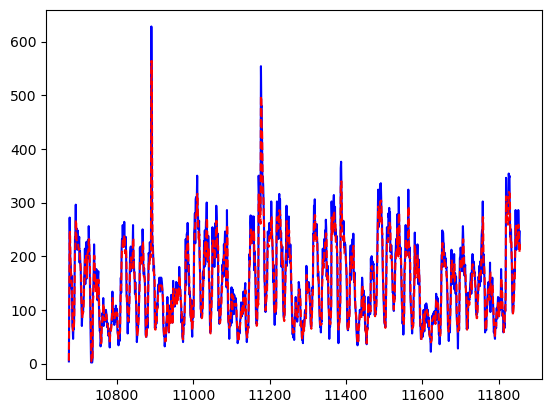

In [64]:
plt.plot(x, y_test_values, label='Gerçek Değerler', color='blue')
plt.plot(x, y_pred_cnn, label='Tahmin Değerleri', color='red', linestyle='--')

In [65]:
mae = mean_absolute_error(y_test,y_pred_cnn)
mse = mean_squared_error(y_test,y_pred_cnn)
mape= mean_absolute_percentage_error(y_test,y_pred_cnn)
rmse =np.sqrt(mse)
print("mae:",mae)
print("mse:",mse)
print("mape:",mape)
print("rmse:",rmse)

mae: 15.657956563478395
mse: 424.7630988334777
mape: 0.14262524034329158
rmse: 20.609781629931884


# MLP

In [81]:
def create_mlp(input_shape):
    model=Sequential()
    ## MLP'de Conv1D gerekmez. 
    model.add(Dense(units=32,activation="relu",input_shape=input_shape))
    model.add(Dense(32,activation="relu"))
    model.add(Dense(32,activation="relu"))  
    model.add(Dense(1))
    model.compile(optimizer="adam",loss="mean_squared_error")
    return model

In [82]:
input_shape = (X_train.shape[1],)

In [83]:
mlp_model=create_mlp(input_shape)

C:\Users\data2\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
y_pred_mlp = forecast(mlp_model,lagged_train,lagged_test,"mlp_model")

Epoch 1/10
334/334 - 5s - 15ms/step - loss: 645.8387
Epoch 2/10
334/334 - 3s - 8ms/step - loss: 454.8472
Epoch 3/10
334/334 - 2s - 5ms/step - loss: 440.3362
Epoch 4/10
334/334 - 3s - 9ms/step - loss: 440.3802
Epoch 5/10
334/334 - 1s - 4ms/step - loss: 437.4955
Epoch 6/10
334/334 - 2s - 4ms/step - loss: 444.9797
Epoch 7/10
334/334 - 1s - 2ms/step - loss: 435.5244
Epoch 8/10
334/334 - 2s - 7ms/step - loss: 438.4619
Epoch 9/10
334/334 - 1s - 3ms/step - loss: 433.1077
Epoch 10/10
334/334 - 1s - 3ms/step - loss: 432.0330
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [96]:
axis=y_test.index

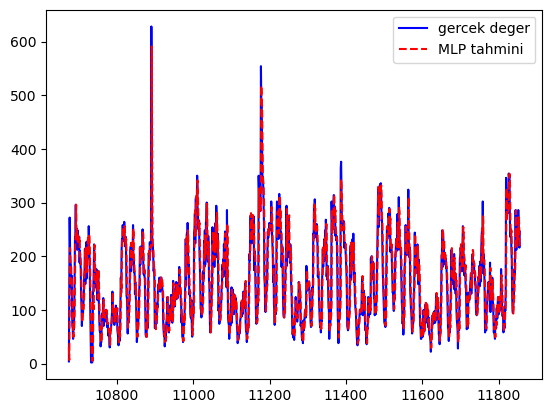

In [106]:
plt.plot(axis,y_test.values,color="blue",label="gercek deger")
plt.plot(axis,y_pred_mlp,color="red",label="MLP tahmini",linestyle="--")
plt.legend()

In [89]:
mae = mean_absolute_error(y_test,y_pred_mlp)
mse = mean_squared_error(y_test,y_pred_mlp)
mape= mean_absolute_percentage_error(y_test,y_pred_mlp)
rmse =np.sqrt(mse)
print("mae:",mae)
print("mse:",mse)
print("mape:",mape)
print("rmse:",rmse)

mae: 26.455608456267925
mse: 1501.2841994714236
mape: 0.25558822284515526
rmse: 38.746408859033934


# LSTM

In [305]:
from tensorflow.keras.layers import LSTM

In [316]:
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=64,activation="tanh" ,input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))  
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [317]:
X_train_reshaped=X_train.values.reshape(-1,4,1)
X_test_reshaped=X_test.values.reshape(-1,4,1)

In [318]:
input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])

In [319]:
lstm_model=create_lstm(input_shape)

C:\Users\data2\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [320]:
y_pred_lstm= forecast(lstm_model,lagged_train,lagged_test,"lstm_model",4)

Epoch 1/15
334/334 - 11s - 34ms/step - loss: 4795.2578
Epoch 2/15
334/334 - 3s - 10ms/step - loss: 4017.5994
Epoch 3/15
334/334 - 5s - 16ms/step - loss: 3468.9570
Epoch 4/15
334/334 - 3s - 8ms/step - loss: 3029.7869
Epoch 5/15
334/334 - 3s - 10ms/step - loss: 2668.7053
Epoch 6/15
334/334 - 4s - 11ms/step - loss: 2366.0662
Epoch 7/15
334/334 - 4s - 12ms/step - loss: 2112.1709
Epoch 8/15
334/334 - 5s - 15ms/step - loss: 1894.0391
Epoch 9/15
334/334 - 5s - 15ms/step - loss: 1710.0483
Epoch 10/15
334/334 - 3s - 10ms/step - loss: 1548.8689
Epoch 11/15
334/334 - 6s - 17ms/step - loss: 1408.9020
Epoch 12/15
334/334 - 4s - 12ms/step - loss: 1289.0249
Epoch 13/15
334/334 - 4s - 12ms/step - loss: 1180.8383
Epoch 14/15
334/334 - 4s - 12ms/step - loss: 1086.5873
Epoch 15/15
334/334 - 4s - 12ms/step - loss: 1003.1369
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


In [322]:
axis = y_test.index

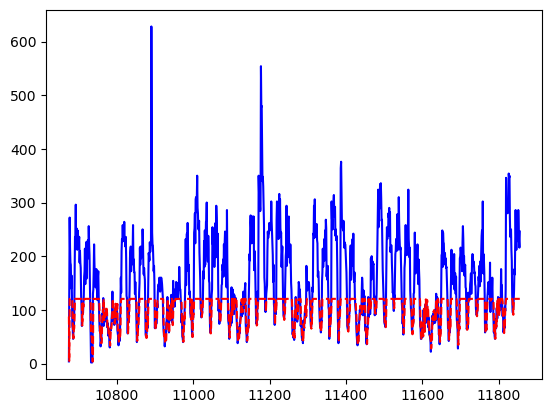

In [323]:
plt.plot(axis,y_test.values,label="test degerleri",color="blue")
plt.plot(axis,y_pred_lstm,label="lstm tahminleri",color="red",linestyle="--")

In [324]:
mae = mean_absolute_error(y_test,y_pred_lstm)
mse = mean_squared_error(y_test,y_pred_lstm)
mape= mean_absolute_percentage_error(y_test,y_pred_lstm)
rmse =np.sqrt(mse)
print("mae:",mae)
print("mse:",mse)
print("mape:",mape)
print("rmse:",rmse)

mae: 56.87000354716015
mse: 6529.7680446939485
mape: 0.4047104347658162
rmse: 80.80698017308869


### bir cok activation ve units parametrelerini degistridim ama gene de MLP ve CNN gibi basarili sonuclar alamadim

# Psuedo veya denemeler :))/

# CNN (Fonksiyonsuz)

## Standartizasyon

In [153]:
from sklearn.preprocessing import StandardScaler 

In [154]:
scaler=StandardScaler()

In [155]:
X_train_scaled=scaler.fit_transform(X_train)

In [156]:
X_test_scaled = scaler.fit_transform(X_test)

## CNN katmanlar icin ReShape   tensor (3D) veri ister 

In [51]:
X_train_scaled.shape

NameError: name 'X_train_scaled' is not defined

In [52]:
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0],X_train_scaled.shape[1],1))

NameError: name 'X_train_scaled' is not defined

In [160]:
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0],X_test_scaled.shape[1],1)

In [161]:
print(X_train_cnn.shape,X_test_cnn.shape)

(10670, 4, 1) (1182, 4, 1)


## TensorFlow

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [182]:
model =Sequential()

In [183]:
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))

C:\Users\data2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3- Pooling 

In [165]:
model.add(MaxPooling1D(pool_size=2))

## 4- Flatting [i,j] -> [ixj,1]

In [166]:
model.add(Flatten())
## neural network olmadan once flatten olmasi gerekir

In [ ]:
## Layer olusturma

In [188]:
## input katmani buraya da yazilabilir (daha clean bir kod)
## units= neuron sayisi her bir dense ise Layer
model.add(Dense(units=50,activation="relu"))
"""
model.add(Dense(units=50,activation="relu"))
model.add(Dense(units=25,activation="relu"))
"""
model.add(Dense(1))

In [171]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [172]:
history = model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1132.7268 - val_loss: 1905.1538
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 217.5972 - val_loss: 1740.9010
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 218.2724 - val_loss: 1785.2335
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 219.9540 - val_loss: 1936.3363
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 207.2938 - val_loss: 1811.3142
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 258.4953 - val_loss: 1785.1033
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 222.1453 - val_loss: 1658.2356
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 213.2161 - val_loss: 2064.6711
Epoch 9/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 205.3016 - val_loss: 1856.5114
Epoch 10/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 210.1431 - val_loss: 1648.2284
Epoch 11/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 207.9838 - val_loss: 1

In [173]:
y_pred = model.predict(X_test_cnn)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


 Veriyi 3D şekline getirme (num_samples, timesteps, num_features)
burada ne anlatiyor ve neden yapariz kucuk bir ornekle goster
X_train_reshaped.shape

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Test verisinin gerçek değerleri
y_test_actual = lagged_test['Count'].values

# Tahminler ile gerçek değerler arasındaki hata hesaplanır
mse = mean_squared_error(y_test_actual, cnn_forecast)
mae = mean_absolute_error(y_test_actual, cnn_forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')


cnn_forecast = forecast(cnn_model, lagged_train, lagged_test, n_forecast)


def forecast(model, train_data, test_data, n_forecast):
    forecasts = []
    history = train_data.copy()

    # Test veri seti boyunca tahmin yapma
    for _ in range(n_forecast):
        # Veriyi hazırlama
        X = history.drop('Count', axis=1).values  # Lag özellikleri
        y = history['Count'].values  # Hedef değişken
        
        # Veriyi uygun şekilde reshape etme
        X = X.reshape((X.shape[0], X.shape[1], 1))  # CNN ve LSTM için gerekli
        
        # Modeli eğit
        model.fit(X, y, epochs=2, verbose=2)
        
        # Son girdi verisinden tahmin yap
        next_input = X[-1].reshape((1, X.shape[1], 1))
        next_forecast = model.predict(next_input)
        
        # Yeni tahmini geçmişe ekle
        next_row = pd.DataFrame([{**{'Count': next_forecast[0][0]}, **history.iloc[-1].to_dict()}])
        history = pd.concat([history, next_row], ignore_index=True)
        forecasts.append(next_forecast[0][0])
    
    return forecasts


train=lag_df.iloc[:doksan]
test=lag_df.iloc[doksan:]
y=pd.DataFrame(df["Count"])
train.drop("Datetime", axis=1 , inplace =True)
test.drop("Datetime", axis=1 , inplace =True)
plt.plot(y_pred)
X_train = train.set_index(train["Datetime"])
Zorunluluk degil ama .values ile verileri numpy yaparak kutuphane stabilitesini ve olasi sorunlara mudahale etme alani kazanirsin
